In [1]:
import abjad
%load_ext abjad.ext.ipython

## Designing Interactions Between Two or More Custom Classes
In our last notebook, we saw what can be done with multiple instances of a single custom class. In this notebook, we will define a second custom class and demonstrate one way it might interact with instances of our first class: one class instance gets passed into another as an optional keyword argument.

## 1. Define the `AttachmentMaker()` Class
First, we define a second custom class that will traverse a selection of music and attach indicators and/or spanners to it. We will give each instance of this class (1) the kind of attachment (indicator or spanner) to make, and (2) a selector that will determine how the attacher will traverse the music to make the attachments.

N. B. We also need to import Python's `copy` module, because our class needs to generate a new slur, accent, etc. for each attachment.

In [2]:
import copy

class AttachmentMaker(object):
    """
    An attachment-making machine.
    """

    def __init__(self, attachment, selector):
        self.attachment = attachment
        self.selector = selector

    def __call__(self, music):
        for selection in self.selector(music):
            attachment = copy.copy(self.attachment)
            abjad.attach(attachment, selection)

## 2. Add a New Keyword Argument and a New Method to the MusicMaker Class
Let's add a new keyword argument to our existing `MusicMaker()` class's initializer, so that we will be newly able to pass in `AttachmentMakere()` instances to instances of `MusicMaker()`. We will also add a new method to the class that passes the music into the `AttachmentMaker()` instance to add the attachments to the music.

### The `__call__` Method
Note that instead of the `make_music()` method we had before, we've made instances of `MusicMaker()` callable; that is, to make music, we call the class instance as if it were a function, i.e. `musicmaker_instance()`. As before, we pass our time signature pairs into the instance when we call it, to generate the music.

### Private Methods
Notice also that we've prefixed the class definition's methods with initial underscores. This indicates that these methods are used internally by the class but that the user should not access and use the methods.

### The New Class Definition
And finally, here is the modified `MusicMaker()` class, including (1) private methods, (2) a new keyword argument for `AttachmentMaker()` instances, and (3) a new method that allows `AttachmentMaker()` instances to attach indicators and spanners to the generated music.

In [1]:
class MusicMaker(object):
    """
    A music-making machine.
    """

    def __init__(
        self,
        counts,
        denominator,
        pitches,
        attachment_makers=None,
        ):
        self.counts = counts
        self.denominator = denominator
        self.pitches = pitches
        self.attachment_makers = attachment_makers or []

    def __call__(self, time_signature_pairs):
        music = self._make_basic_rhythm(
            time_signature_pairs,
            self.counts,
            self.denominator,
            )
        music = self._clean_up_rhythm(music, time_signature_pairs)
        music = self._add_pitches(music, self.pitches)
        music = self._add_attachments(music)
        return music

    def _make_basic_rhythm(self, time_signature_pairs, counts, denominator):
        """
        Make a basic rhythm using ``time_signature_pairs``, ``counts`` and
        ``denominator``.
        """
        total_duration = sum(
            abjad.Duration(pair) for pair in time_signature_pairs
            )
        talea = abjad.rhythmmakertools.Talea(
            counts=counts,
            denominator=denominator,
            )
        talea_index = 0
        all_leaves = []
        current_duration = abjad.Duration(0)
        while current_duration < total_duration:
            leaf_duration = talea[talea_index]
            if leaf_duration > 0:
                pitch = abjad.NamedPitch("c'")
            else:
                pitch = None
            leaf_duration = abs(leaf_duration)
            if (leaf_duration + current_duration) > total_duration:
                leaf_duration = total_duration - current_duration
            current_leaves = abjad.LeafMaker()([pitch], [leaf_duration])
            all_leaves.extend(current_leaves)
            current_duration += leaf_duration
            talea_index += 1
        music = abjad.Container(all_leaves)
        return music

    def _clean_up_rhythm(self, music, time_signature_pairs):
        """
        Clean up rhythms in ``music`` via ``time_signature_pairs``.
        """
        shards = abjad.mutate(music[:]).split(time_signature_pairs)
        for i, shard in enumerate(shards):
            time_signature_pair = time_signature_pairs[i]
            measure = abjad.Measure(time_signature_pair)
            assert shard.get_duration() == abjad.Duration(
                time_signature_pair)
            abjad.mutate(shard).wrap(measure)
        return music

    def _add_pitches(self, music, pitches):
        """
        Add ``pitches`` to music.
        """
        pitches = abjad.CyclicTuple(pitches)
        logical_ties = abjad.iterate(music).by_logical_tie(pitched=True)
        for i, logical_tie in enumerate(logical_ties):
            pitch = pitches[i]
            for note in logical_tie:
                note.written_pitch = pitch
        return music

    def _add_attachments(self, music):
        """
        Add attachments to ``music``.
        """
        for attachment_maker in self.attachment_makers:
            attachment_maker(music)
        return music

## 3.  Initializing Some Attachment Makers
Now that we have defined a new class and revised the existing class to be able to interact with the new class, we can use both classes in conjunction with one another.

First, we can initialize attachment makers to be passed into a music maker.

In [2]:
slur_attachment_maker = AttachmentMaker(
    attachment=abjad.Slur(),
    selector=abjad.select().by_leaf().by_run((abjad.Note, abjad.Chord))
    )


accent_attachment_maker = AttachmentMaker(
    attachment=abjad.Articulation('accent'),
    selector=abjad.select().by_leaf().by_run((abjad.Note, abjad.Chord))[0]
    )

NameError: name 'AttachmentMaker' is not defined

The first attachment maker will attach a slur to any consecutive run of notes and/or chords, while the second will attach accents to the first leaf in any runs of consecutive notes and/or chords.

## 4. Initialize a Music Maker and Pass the Attachmenet Makers in via the Keyword Argument
Just as we did before, we initialize an instance of the `MusicMaker()` class, passing in the attachment makers as keyword arguments; then, unlike last time, to generate the music, we call the instance itself and pass in the list of time signatures as arguments to generate the music.

In [9]:
fast_music_maker = MusicMaker(
    counts=[1, 1, 1, 1, 1, -1],
    denominator=16,
    pitches=[0, 1],
    attachment_makers=[
        slur_attachment_maker,
        accent_attachment_maker,
        ],
    )

music = fast_music_maker([(3, 4), (5, 8), (4, 4)] * 10)

## 5. Score Construction, Layout, and Formatting
Finally, we create the final score and use it to initialize an instance of the `LilyPondFile()` class. This time, we will pass a stylesheet as a keyword argument into the initializer function, which allows us to specify additional layout and typographical details.

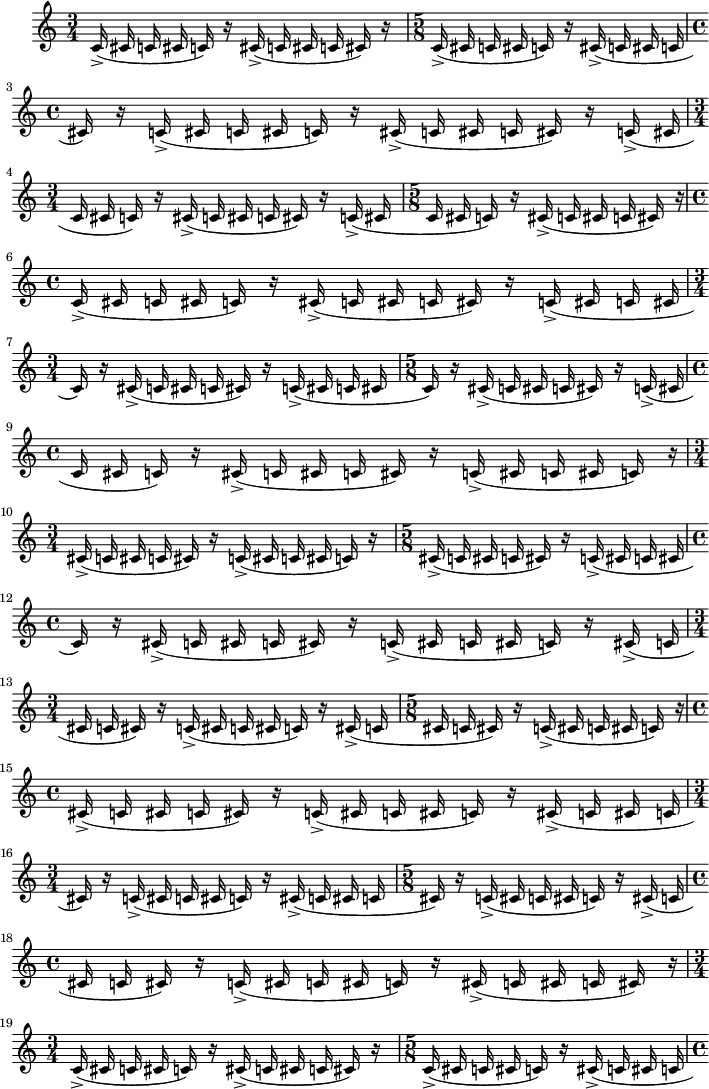

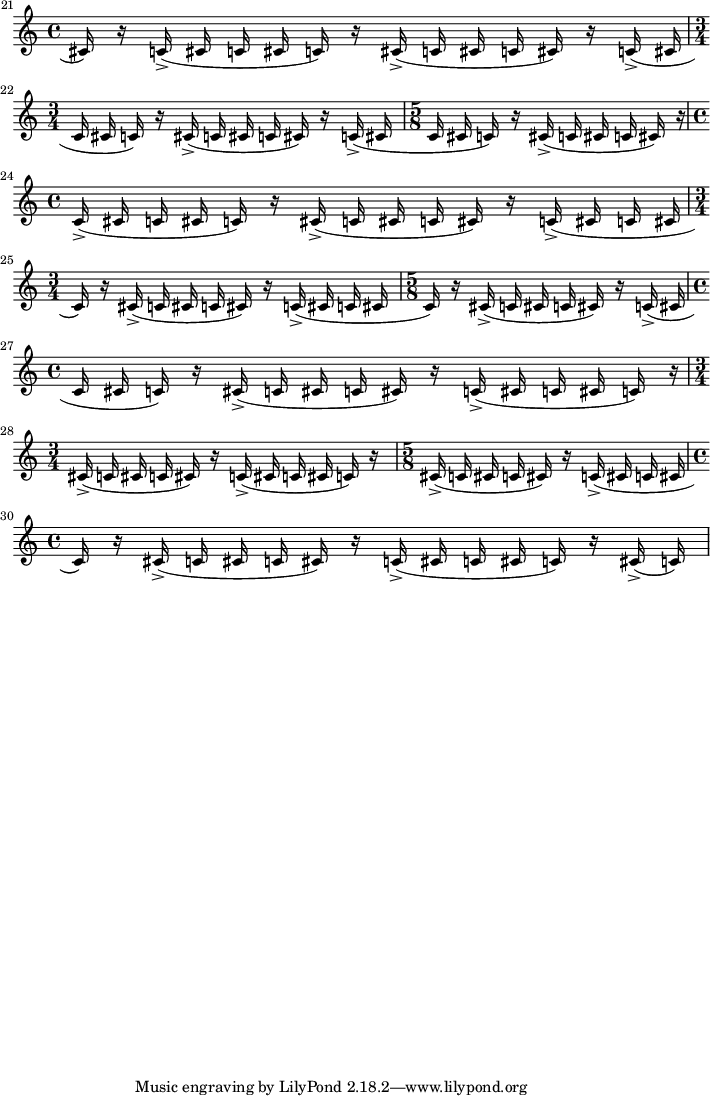

In [10]:
staff = abjad.Staff([music])
score = abjad.Score([staff])
lilypond_file = abjad.LilyPondFile.new(
    music=score,
    includes=['stylesheet.ily'],
    )

abjad.show(lilypond_file)

## Conclusion
This notebook has illustrated the way that interactions between two or more custom classes can begin to model multidimensional gestural comportments in the process of compositional modeling.